Реализовав сверточную нейронную сеть при помощи Pytorch, решите задачу классификации изображений. Разделите набор данных на обучающее и тестовое множество. Выполните предобработку данных(приведите изображения к одному размеру и преобразуйте в тензоры). Отобразите графики значений функции потерь на обучающем множестве. Отобразите confusion matrix и classification report, рассчитанные на основе тестового множества.

Датасет images/chars


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

32*32

128*128

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Оставляем сверточные слои без изменений
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


base_transform = transforms.Compose([
    transforms.Resize((128, 128)), 
])
train_transform = transforms.Compose([
    *base_transform.transforms,
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [28]:
data_path = 'images/chars'
dataset = datasets.ImageFolder(root=data_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SimpleCNN() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10
------------------------------------------------------------
Train Loss: 0.8076 Acc: 0.5283
Test Loss: 0.6695 Acc: 0.6119

Epoch 2/10
------------------------------------------------------------
Train Loss: 0.6817 Acc: 0.5736
Test Loss: 0.6762 Acc: 0.6119

Epoch 3/10
------------------------------------------------------------
Train Loss: 0.6676 Acc: 0.5736
Test Loss: 0.6241 Acc: 0.6119

Epoch 4/10
------------------------------------------------------------
Train Loss: 0.6156 Acc: 0.6377
Test Loss: 0.5870 Acc: 0.7313

Epoch 5/10
------------------------------------------------------------
Train Loss: 0.5561 Acc: 0.6981
Test Loss: 0.5626 Acc: 0.7015

Epoch 6/10
------------------------------------------------------------
Train Loss: 0.4861 Acc: 0.7245
Test Loss: 0.5338 Acc: 0.7164

Epoch 7/10
------------------------------------------------------------
Train Loss: 0.4119 Acc: 0.8113
Test Loss: 0.6074 Acc: 0.7015

Epoch 8/10
---------------------------------------------------

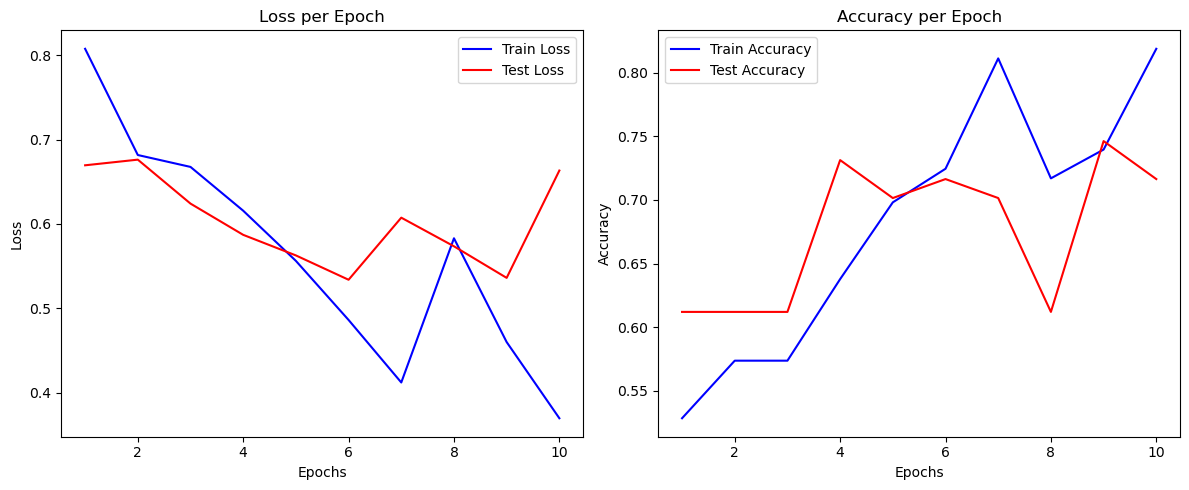

In [30]:
num_epochs=10
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        train_epoch_loss = running_loss / len(train_loader.dataset)
        train_epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_acc)

        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        test_epoch_loss = running_loss / len(test_loader.dataset)
        test_epoch_acc = running_corrects.double() / len(test_loader.dataset)
        test_losses.append(test_epoch_loss)
        test_accuracies.append(test_epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        print(f'Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}\n')

    return train_losses, train_accuracies, test_losses, test_accuracies

train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs
)

def plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies)

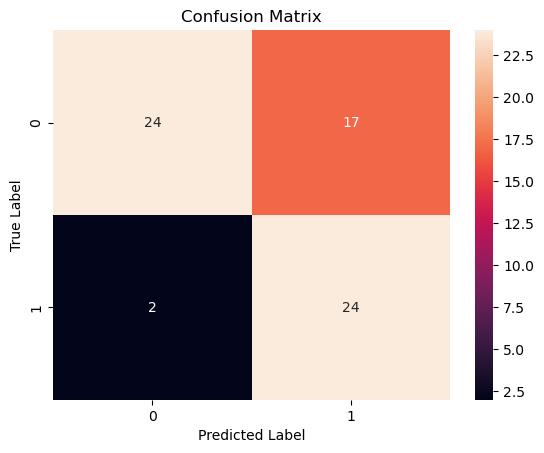

              precision    recall  f1-score   support

           0       0.92      0.59      0.72        41
           1       0.59      0.92      0.72        26

    accuracy                           0.72        67
   macro avg       0.75      0.75      0.72        67
weighted avg       0.79      0.72      0.72        67



In [31]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(classification_report(y_true, y_pred))

evaluate_model(model, test_loader)

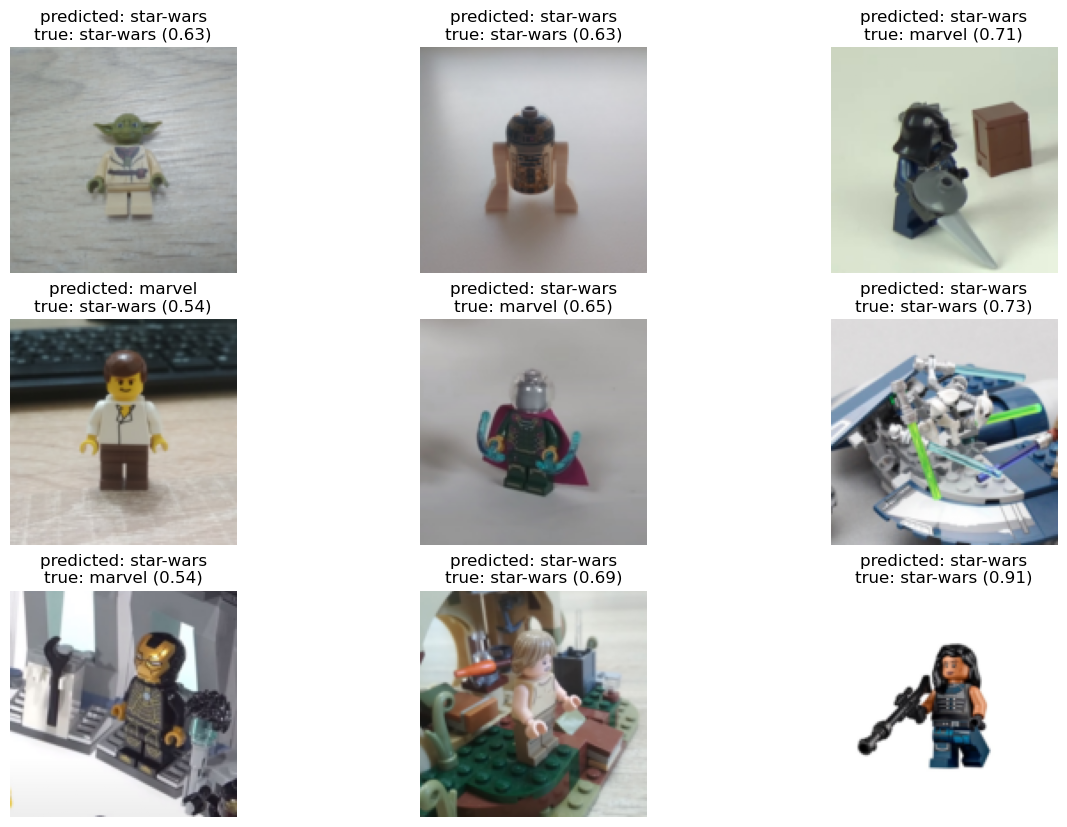

In [32]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
device = 'cpu'
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)  

def visualize_model(model, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))  

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}\ntrue: {} ({:.2f})'.format(
                    dataset.classes[preds[j]], dataset.classes[labels[j]], probabilities[j][preds[j]].item()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()  
                    return
        model.train(mode=was_training)

visualize_model(model, num_images=9)  